# The Freshman Plague

*Modeling and Simulation in Python*

Copyright 2021 Allen Downey

License: [Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# install Pint if necessary

try:
    import pint
except ImportError:
    !pip install pint

In [2]:
# download modsim.py if necessary

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

In [1]:
# import functions from modsim

from modsim import *

In [4]:
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'chap11.py')

In [3]:
# import code from previous notebooks

from chap11 import make_system
from chap11 import update_func
from chap11 import run_simulation

ModuleNotFoundError: No module named 'chap11'

[Click here to run this case study on Colab](https://colab.research.google.com/github/AllenDowney/ModSimPy/blob/master/examples/plague.ipynb)

In [4]:
def make_system(beta, gamma) -> System:
    init = State(s=89, i=1, r=0)
    init /= init.sum()
    return System(init=init, t_end=7*14, beta=beta, gamma=gamma)

def update_func(t, state, system):
    s, i, r = state.s, state.i, state.r
    infected = system.beta * i * s
    recovered = system.gamma * i
    s -= infected
    i += infected - recovered
    r += recovered
    return State(s=s, i=i, r=r)

def run_simulation(system, update_func):
    frame = TimeFrame(columns=system.init.index)
    frame.loc[0] = system.init
    for t in range(0, system.t_end):
        frame.loc[t+1] = update_func(t, frame.loc[t], system)
    return frame

This case study picks up where Chapter 12 leaves off.

In [5]:
def add_immunization(system, fraction):
    system.init.s -= fraction
    system.init.r += fraction

In [6]:
tc = 3             # time between contacts in days 
tr = 4             # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

In [7]:
def calc_total_infected(results, system):
    s_0 = results.s[0]
    s_end = results.s[system.t_end]
    return s_0 - s_end

## Hand washing

Suppose you are the Dean of Student Life, and you have a budget of just \$1200 to combat the Freshman Plague. You have two options for spending this money:

1.  You can pay for vaccinations, at a rate of \$100 per dose.

2.  You can spend money on a campaign to remind students to wash hands
    frequently.

We have already seen how we can model the effect of vaccination. Now
let's think about the hand-washing campaign. We'll have to answer two
questions:

1.  How should we incorporate the effect of hand washing in the model?

2.  How should we quantify the effect of the money we spend on a
    hand-washing campaign?

For the sake of simplicity, let's assume that we have data from a
similar campaign at another school showing that a well-funded campaign
can change student behavior enough to reduce the infection rate by 20%.

In terms of the model, hand washing has the effect of reducing `beta`.
That's not the only way we could incorporate the effect, but it seems
reasonable and it's easy to implement.

Now we have to model the relationship between the money we spend and the
effectiveness of the campaign. Again, let's suppose we have data from
another school that suggests:

-   If we spend \$500 on posters, materials, and staff time, we can
    change student behavior in a way that decreases the effective value of `beta` by 10%.

-   If we spend \$1000, the total decrease in `beta` is almost 20%.

-   Above \$1000, additional spending has little additional benefit.

## Logistic function

To model the effect of a hand-washing campaign, I'll use a [generalized logistic function](https://en.wikipedia.org/wiki/Generalised_logistic_function) (GLF), which is a convenient function for modeling curves that have a generally sigmoid shape.  The parameters of the GLF correspond to various features of the curve in a way that makes it easy to find a function that has the shape you want, based on data or background information about the scenario.

In [8]:
from numpy import exp

def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q * exp(exponent)
    return A + (K-A) / denom ** (1/nu)

The following array represents the range of possible spending.

In [9]:
spending = linspace(0, 1200, 21)

`compute_factor` computes the reduction in `beta` for a given level of campaign spending.

`M` is chosen so the transition happens around \$500.

`K` is the maximum reduction in `beta`, 20%.

`B` is chosen by trial and error to yield a curve that seems feasible.

In [10]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

Here's what it looks like.

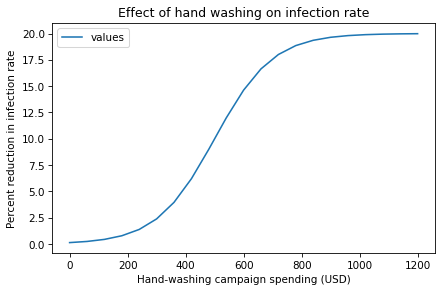

In [11]:
percent_reduction = compute_factor(spending) * 100

make_series(spending, percent_reduction).plot()

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate')

In [12]:
percent_reduction

array([ 0.13385702,  0.2425687 ,  0.43762542,  0.78331446,  1.38276841,
        2.38405844,  3.95632223,  6.20051038,  9.00332005, 11.9737532 ,
       14.62117157, 16.6403677 , 18.00499022, 18.85351648, 19.35409071,
       19.6402758 , 19.80096396, 19.89027402, 19.93963167, 19.96682398,
       19.98177898])

The result is the following function, which
takes spending as a parameter and returns `factor`, which is the factor
by which `beta` is reduced:

In [13]:
def compute_factor(spending):
    return logistic(spending, M=500, K=0.2, B=0.01)

I use `compute_factor` to write `add_hand_washing`, which takes a
`System` object and a budget, and modifies `system.beta` to model the
effect of hand washing:

In [14]:
def add_hand_washing(system, spending):
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

Now we can sweep a range of values for `spending` and use the simulation
to compute the effect:

In [15]:
def sweep_hand_washing(spending_array):
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results, system)
        
    return sweep

Here's how we run it:

In [16]:
from numpy import linspace

spending_array = linspace(0, 1200, 20)
infected_sweep2 = sweep_hand_washing(spending_array)

The following figure shows the result. 

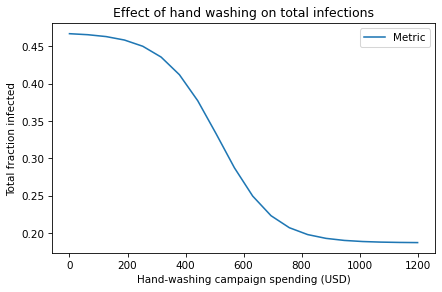

In [17]:
infected_sweep2.plot()

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections')

Below \$200, the campaign has little effect. 

At \$800 it has a substantial effect, reducing total infections from more than 45% to about 20%. 

Above \$800, the additional benefit is small.

## Optimization

Let's put it all together. With a fixed budget of \$1200, we have to
decide how many doses of vaccine to buy and how much to spend on the
hand-washing campaign.

Here are the parameters:

In [18]:
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
max_doses

12

The fraction `budget/price_per_dose` might not be an integer. `int` is a
built-in function that converts numbers to integers, rounding down.

We'll sweep the range of possible doses:

In [20]:
dose_array = linrange(max_doses)
dose_array

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.])

In this example we call `linrange` with only one argument; it returns a NumPy array with the integers from 0 to `max_doses`, including both.

Then we run the simulation for each element of `dose_array`:

In [21]:
def sweep_doses(dose_array):
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results, system)

    return sweep

For each number of doses, we compute the fraction of students we can
immunize, `fraction` and the remaining budget we can spend on the
campaign, `spending`. Then we run the simulation with those quantities
and store the number of infections.

The following figure shows the result.

In [22]:
infected_sweep3 = sweep_doses(dose_array)

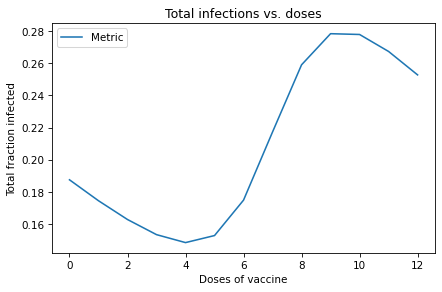

In [23]:
infected_sweep3.plot()

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses')

If we buy no doses of vaccine and spend the entire budget on the campaign, the fraction infected is around 19%. At 4 doses, we have \$800 left for the campaign, and this is the optimal point that minimizes the number of students who get sick.

As we increase the number of doses, we have to cut campaign spending,
which turns out to make things worse. But interestingly, when we get
above 10 doses, the effect of herd immunity starts to kick in, and the
number of sick students goes down again.

**Exercise:** Suppose the price of the vaccine drops to $50 per dose.  How does that affect the optimal allocation of the spending?

In [25]:
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)

In [26]:
infected_sweep4 = sweep_doses(dose_array)

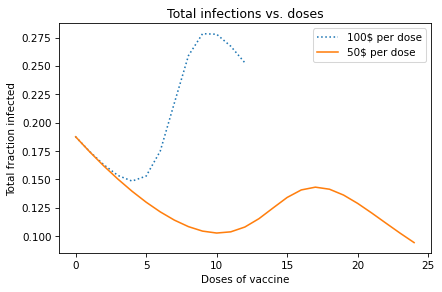

In [28]:
infected_sweep3.plot(label='100$ per dose', style=':')
infected_sweep4.plot(label='50$ per dose')

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses')